# In this project, I have used 1D convolutional layer to classify the sentiment of imdb reviews with subword tokens of size 8000 (8k)

### Import the necessary libraries and dataset

In [1]:
import tensorflow_datasets as tfds

In [3]:
dataset, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)
info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete6J0IZW/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete6J0IZW/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete6J0IZW/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/subwords8k/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Uses `tfds.deprecated.text.SubwordTextEncoder` with 8k vocab size
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir=PosixGPath('/tmp/tmpt_xm5j1gtfds'),
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=54.72 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(None,), dtype=int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False

In [4]:
# Get the tokenizer
tokenizer = info.features['text'].encoder

### preprocess the training and testing data

In [6]:
# Get the train and test data
train_dataset, test_dataset = dataset['train'], dataset['test']

# Set the buffer size for shuffling
buffer_size = 12000

# Shuffle the train_dataset
train_dataset_shuffled = train_dataset.shuffle(buffer_size)

# Set the batch size for training
batch_size = 256

# Pad the training and testing dataset
train_data = train_dataset_shuffled.padded_batch(batch_size)
test_data = test_dataset.padded_batch(batch_size)

### Build and compile the model with convolutional network

In [10]:
import tensorflow as tf
from tensorflow import keras

# Define the hyperparameters of the model
emd_dim = 8
dense_dim = 8
conv_kernel_size = 5
num_kernels = 128

model = keras.Sequential([
    keras.layers.Embedding(tokenizer.vocab_size, emd_dim),
    keras.layers.Convolution1D(num_kernels, conv_kernel_size, activation=tf.nn.relu),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(dense_dim, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 8)           65480     
                                                                 
 conv1d_2 (Conv1D)           (None, None, 128)         5248      
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_4 (Dense)             (None, 8)                 1032      
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 71769 (280.35 KB)
Trainable params: 71769 (280.35 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [11]:
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(), metrics=keras.metrics.Accuracy())

### Train the model and plot the accuracy

In [12]:
# Define the number of epochs
num_epoch = 4

# Train the model
history = model.fit(train_data, epochs=num_epoch, validation_data=test_data)

Epoch 1/4
98/98 [==============================] - 150s 2s/step - loss: 0.6919 - accuracy: 0.0000e+00 - val_loss: 0.6844 - val_accuracy: 0.0000e+00
Epoch 2/4
98/98 [==============================] - 142s 1s/step - loss: 0.6108 - accuracy: 0.0000e+00 - val_loss: 0.5319 - val_accuracy: 0.0000e+00
Epoch 3/4
98/98 [==============================] - 139s 1s/step - loss: 0.4785 - accuracy: 0.0000e+00 - val_loss: 0.4665 - val_accuracy: 0.0000e+00
Epoch 4/4
98/98 [==============================] - 126s 1s/step - loss: 0.4067 - accuracy: 0.0000e+00 - val_loss: 0.4394 - val_accuracy: 0.0000e+00


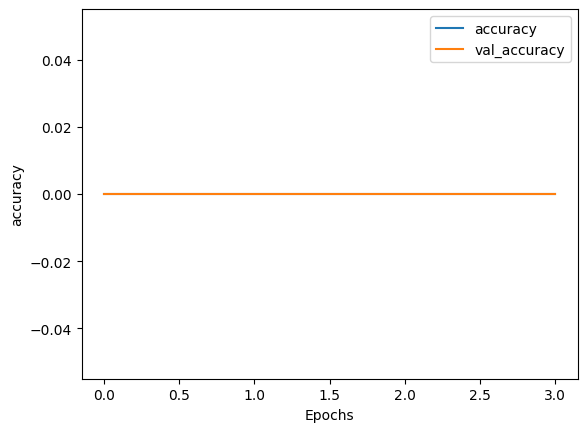

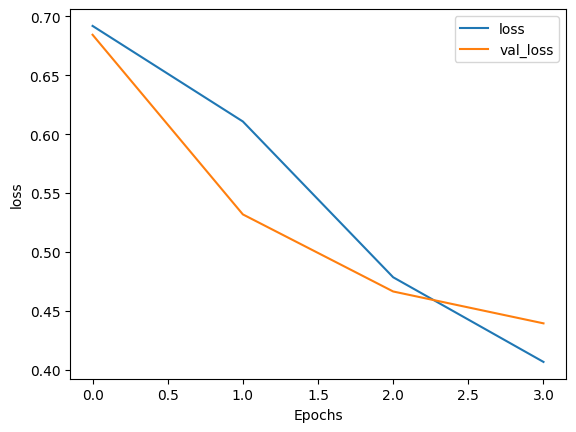

In [13]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and results
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")